In [1]:
import pandas as pd
art = pd.read_csv('article_dat.csv')
model = pd.read_csv('model_dat.csv')

In [5]:
# Merge the model and article datasets on 'doi'
# merged_df = pd.merge(model, art, on='doi', how='left')
# merged_df.to_csv('main.csv', index=False)

(                                doi                    outcome measure  \
 count                          6762                       6762    6762   
 unique                          299                        983      83   
 top     10.1016/j.ygyno.2018.02.019  Primary Cesarean Delivery      OR   
 freq                            212                        176    1958   
 mean                            NaN                        NaN     NaN   
 std                             NaN                        NaN     NaN   
 min                             NaN                        NaN     NaN   
 25%                             NaN                        NaN     NaN   
 50%                             NaN                        NaN     NaN   
 75%                             NaN                        NaN     NaN   
 max                             NaN                        NaN     NaN   
 
                point         lower         upper  treatment_received  \
 count   6.762000e+03   6

In [7]:
df = pd.read_csv('main.csv')

# Display the first few rows and the column names
df.head(), df.columns.tolist()


(                            doi  model_number stratified  \
 0  10.1097/AOG.0000000000003552             1        Yes   
 1  10.1097/AOG.0000000000003552             1        Yes   
 2  10.1097/AOG.0000000000003552             1        Yes   
 3  10.1097/AOG.0000000000003552             1        Yes   
 4  10.1097/AOG.0000000000003552             1        Yes   
 
                                             stratgrp subanalysis subgrp  \
 0  Achieved sterilization at time of cesarean del...          No    NaN   
 1  Achieved sterilization at time of cesarean del...          No    NaN   
 2  Achieved sterilization at time of cesarean del...          No    NaN   
 3  Achieved sterilization at time of cesarean del...          No    NaN   
 4  Achieved sterilization at time of cesarean del...          No    NaN   
 
                                           outcome  measure measure_comments  \
 0  Sterilization at the time of cesarean delivery  Percent              NaN   
 1  Sterilizat

In [139]:
!pip install rapidfuzz

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.6 MB 326.8 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.6 MB 573.4 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.6 MB 595.3 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.6 MB 748.1 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.6 MB 748.1 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.6 MB 999.9 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.6 MB 873.8 kB/s eta 0:00:02
   ----------- ---------------------------- 0.5/1.6 MB 1.1 MB/s eta 0:00:02
   ------------- -------------------------- 0.6/1.6 MB 1.2 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.6 MB 1.3 MB/s eta 0:00:01
   ----------------

In [163]:
import pandas as pd
import re
from rapidfuzz import process

# Lowercased standardized mapping
race_standardization = {
    'african american': 'Black or African American',
    'african american or black': 'Black or African American',
    'african american, non-hispanic': 'Black or African American',
    'black': 'Black or African American',
    'black or african american': 'Black or African American',
    'black, non-hispanic': 'Black or African American',
    'non african american': 'Black or African American',
    'non-african american': 'Black or African American',
    'non-hispanic black': 'Black or African American',

    'caucasian': 'White',
    'white': 'White',
    'non hispanic white': 'White',
    'non-hispanic white': 'White',
    'non-latina white': 'White',
    'white (non-hispanic)': 'White',
    'white non-hispanic': 'White',
    'white/caucasian': 'White',
    'whites': 'White',
    'u.s.-born, non-hispanic white;': 'White',
    'non-hispanic, white': 'White',
    'white donor / white recipient': 'White',
    'european american': 'White',
    'non hispanic whites': 'White',
    'white, non-hispanic': 'White',

    'hispanic': 'Hispanic or Latino',
    'latina': 'Hispanic or Latino',
    'latino': 'Hispanic or Latino',
    'mexican/american': 'Hispanic or Latino',

    'asian': 'Asian or Pacific Islander',
    'asian, non-hispanic': 'Asian or Pacific Islander',
    'asian american': 'Asian or Pacific Islander',
    'pacific islander': 'Asian or Pacific Islander',

    'american indian': 'American Indian or Alaska Native',
    'american indian/alaska native': 'American Indian or Alaska Native',
    'american indian/alaskan': 'American Indian or Alaska Native',
    'american indian/alaskan native': 'American Indian or Alaska Native',
    'native american': 'American Indian or Alaska Native',
    'non-hispanic american indian or alaska native': 'American Indian or Alaska Native',

    'minority': 'Other / Multiracial',
    'nonwhite': 'Other / Multiracial',
    'non-white': 'Other / Multiracial',
    'urm (black, hispanic, native american/alaskan, asian/pacific islander, and other)': 'Other / Multiracial',
    'other': 'Other / Multiracial',
    'multiracial': 'Other / Multiracial',

    'unknown': 'Unknown / Not Reported',
    'not reported': 'Unknown / Not Reported'
}

def handle_compound_race(label):
    if pd.isna(label):
        return 'Unknown / Not Reported'

    label = label.lower().strip()
    label = re.sub(r'[;:,_]', '/', label)
    label = re.sub(r'\s*(and|or|/)\s*', '/', label)
    parts = [p.strip() for p in label.split('/') if p.strip()]

    matched = set()
    for part in parts:
        if part in race_standardization:
            matched.add(race_standardization[part])
        else:
            match, score, _ = process.extractOne(part, race_standardization.keys())
            if score >= 90:
                matched.add(race_standardization[match])

    if not matched:
        return 'Other / Multiracial'
    elif len(matched) == 1:
        return list(matched)[0]
    else:
        return 'Other / Multiracial'

def standardize_race_labels(series, use_fuzzy=True, fuzzy_threshold=90):
    def normalize(label):
        if pd.isna(label):
            return 'unknown'
        return label.strip().lower()

    def map_label(label):
        if label in race_standardization:
            return race_standardization[label]
        if use_fuzzy:
            match, score, _ = process.extractOne(label, race_standardization.keys())
            if score >= fuzzy_threshold:
                return race_standardization[match]
        return handle_compound_race(label)

    normalized_series = series.apply(normalize)
    standardized_series = normalized_series.apply(map_label)

    original_unmapped = series[~normalized_series.isin(race_standardization.keys())].unique()
    if len(original_unmapped) > 0:
        print("\n⚠️ Unmapped race labels for review:")
        for label in original_unmapped:
            print(f"  - {label}")

    return standardized_series


In [165]:
df['race1_clean'] = standardize_race_labels(df['race1'])

In [167]:
# Get unique values from the outcome and health_outcome columns
unique_outcomes = df['outcome'].dropna().unique()
unique_health_outcomes = df['health_outcome'].dropna().unique()

# Combine and deduplicate the lists
all_outcomes = pd.Series(list(unique_outcomes) + list(unique_health_outcomes)).dropna().unique().tolist()
all_outcomes


['Sterilization at the time of cesarean delivery',
 'Nonachievement of sterilization at time of cesarean delivery',
 'germline testing performed',
 'Somatic testing performed',
 'Germline testing performed',
 'advanced ovarian cancer',
 'endometrioid endometrial cancer survival',
 'non-endometrioid endometrial cancer survival',
 'Ovarian cancer trial accrual',
 'Uterine cancer trial accrual',
 'Cervical cancer trial accrual',
 'All gynecological cancers',
 'Uterine cancer trial accural',
 'Cervical cancer trial accural',
 'Difference in clinical trial accruals and population incidence for ovarian cancer',
 'Difference in clinical trial accruals and population incidence for uterine cancer',
 'likelihood of late treatment',
 'all-cause mortality for patients diagnosed with uterine cancer',
 'Sugery',
 'Chemotherapy',
 'Radiation',
 'Overall mortality',
 'Dying without Hospice',
 'having a medical power of attorney or living will',
 'Sexual activity',
 'Sexual dysfunction in sexually acti

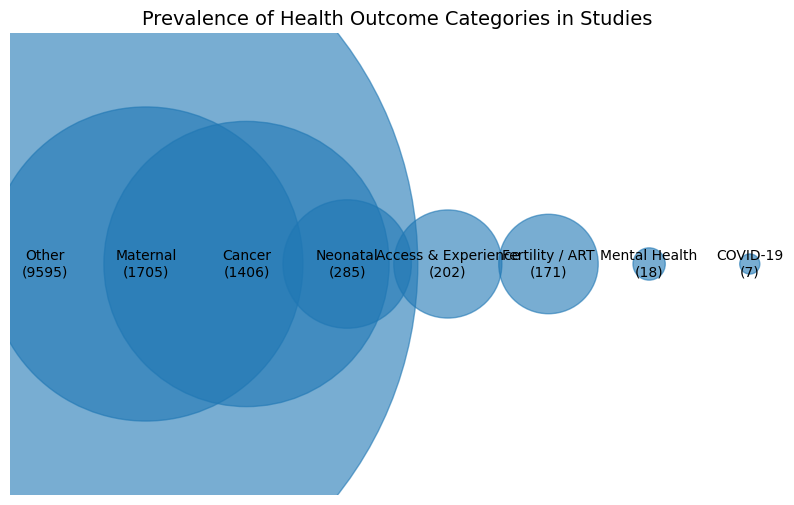

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Broad categories and associated keywords to classify outcomes
category_keywords = {
    'Maternal': ['maternal', 'cesarean', 'pregnancy-related mortality', 'hysterectomy', 'uterine', 'pregnancy', 'transfusion', 'ICU', 'perineal', 'postpartum'],
    'Neonatal': ['neonatal', 'birthweight', 'NICU', 'apgar', 'infant', 'small for gestational age', 'preterm'],
    'Fertility / ART': ['fertility', 'ivf', 'in vitro', 'oocyte', 'assisted reproductive', 'cryopreservation', 'gonadotropin', 'cycle', 'embryo'],
    'Cancer': ['cancer', 'chemotherapy', 'oncology', 'tumor', 'nccn', 'radiotherapy', 'survival'],
    'Mental Health': ['depression', 'stress', 'mental health'],
    'COVID-19': ['covid', 'sars-cov-2', 'coronavirus'],
    'Access & Experience': ['insurance', 'access', 'care', 'pain', 'disparity', 'recommendation letters'],
    'Other': []  # default category for anything not matching above
}

# Function to categorize outcomes
def categorize_outcome(outcome):
    outcome_lower = str(outcome).lower()
    for category, keywords in category_keywords.items():
        if any(re.search(rf"\b{kw}\b", outcome_lower) for kw in keywords):
            return category
    return 'Other'

# Combine and deduplicate all outcomes
unique_outcomes = pd.Series(df['outcome'].dropna().tolist() + df['health_outcome'].dropna().tolist()).dropna()
categorized = unique_outcomes.apply(categorize_outcome)

# Count instances per category
category_counts = categorized.value_counts()

# Plot a bubble chart
plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(category_counts)), y=[1]*len(category_counts), 
            s=category_counts.values * 30, alpha=0.6)

for i, (cat, count) in enumerate(category_counts.items()):
    plt.text(i, 1, f'{cat}\n({count})', ha='center', va='center', fontsize=10)

plt.axis('off')
plt.title("Prevalence of Health Outcome Categories in Studies", fontsize=14)
plt.show()


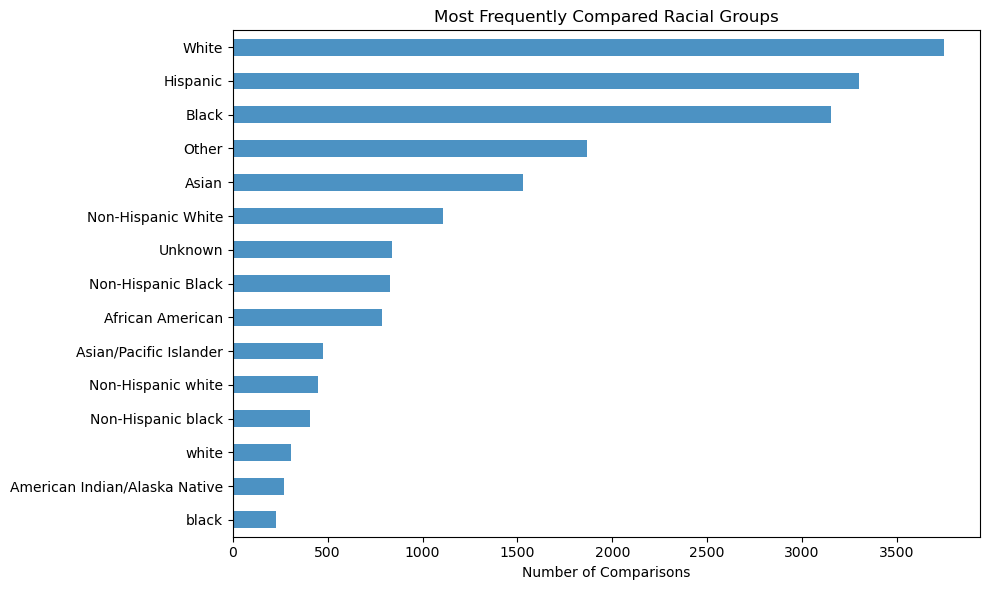

In [170]:
# Collect all racial group values from race columns
race_values = pd.Series(dtype=str)

for col in race_columns:
    race_values = pd.concat([race_values, df[col].dropna().astype(str)])

# Count occurrences of each racial group label
race_counts = race_values.value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
race_counts.head(15).plot(kind='barh', alpha=0.8)
plt.xlabel("Number of Comparisons")
plt.title("Most Frequently Compared Racial Groups")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [173]:
import plotly.express as px
import dash
from dash import dcc, html, Input, Output, ctx
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import plotly.graph_objects as go

In [183]:
from dash import Dash, html, dcc, Input, Output
import plotly.express as px
import pandas as pd

# Assume df is already loaded

app = Dash(__name__)

# --- Preprocess data for dropdown and plots ---
all_races = ['All'] + sorted(df['race1_clean'].dropna().unique().tolist())

category_counts_all = df['health_category'].value_counts().reset_index()
category_counts_all.columns = ['health_category', 'count']

# --- Layout ---
app.layout = html.Div([
    html.H2("Health Outcome Categories by Race"),

    html.Div([
        html.Label("Select Racial Group:"),
        dcc.Dropdown(
            id='race-selector',
            options=[{'label': race, 'value': race} for race in all_races],
            value='All',
            clearable=False
        )
    ], style={'width': '30%', 'marginBottom': '20px'}),

    dcc.Graph(id='category-bubble-chart'),

    html.H4("Top 10 Health Outcomes in Selected Category"),
    dcc.Graph(id='top-outcomes-bar'),

    html.H4("Proportional Distribution of Health Categories by Race"),
    dcc.Graph(id='stacked-bar-chart'),

    html.H4("Heatmap of Health Category Prevalence by Race"),
    dcc.Graph(id='heatmap')
])

# --- Callbacks ---
@app.callback(
    Output('category-bubble-chart', 'figure'),
    Input('race-selector', 'value')
)
def update_bubble_chart(selected_race):
    if selected_race == 'All':
        data = df
    else:
        data = df[df['race1_clean'] == selected_race]

    category_counts = data[data['health_category'] != 'Other']['health_category'].value_counts().reset_index()
    category_counts.columns = ['health_category', 'count']

    fig = px.scatter(
        category_counts,
        x='health_category', y=[1]*len(category_counts),
        size='count', color='count', text='health_category',
        size_max=100, height=400, color_continuous_scale='Viridis_r'
    )
    fig.update_traces(textposition='middle center')
    fig.update_layout(
        showlegend=False,
        xaxis_title='', yaxis_title='',
        yaxis=dict(showticklabels=False),
        title="Prevalence of Health Outcome Categories"
    )
    return fig

@app.callback(
    Output('top-outcomes-bar', 'figure'),
    Input('race-selector', 'value')
)
def update_outcomes_bar(selected_race):
    if selected_race == 'All':
        data = df
    else:
        data = df[df['race1_clean'] == selected_race]

    outcome_counts = data['outcome'].value_counts().head(10).reset_index()
    outcome_counts.columns = ['outcome', 'count']
    outcome_counts = outcome_counts.sort_values('count', ascending=True)

    fig = px.bar(
        outcome_counts,
        x='count', y='outcome', orientation='h',
        color='count', color_continuous_scale='Viridis_r'
    )
    fig.update_layout(title="Top 10 Health Outcomes", yaxis_title="Outcome", xaxis_title="Count")
    return fig

@app.callback(
    Output('stacked-bar-chart', 'figure'),
    Input('race-selector', 'value')
)
def update_stacked_bar(selected_race):
    data = df[df['health_category'] != 'Other']

    if selected_race != 'All':
        data = data[data['race1_clean'] == selected_race]

    grouped = data.groupby(['race1_clean', 'health_category']).size().reset_index(name='count')
    total_per_race = grouped.groupby('race1_clean')['count'].transform('sum')
    grouped['percent'] = (grouped['count'] / total_per_race) * 100

    fig = px.bar(
        grouped,
        x='race1_clean', y='percent', color='health_category',
        title="Health Category Composition by Race (Proportional)",
        labels={'percent': 'Percent (%)', 'race1_clean': 'Race'},
        height=400
    )
    fig.update_layout(barmode='stack')
    return fig


@app.callback(
    Output('heatmap', 'figure'),
    Input('race-selector', 'value')
)
def update_heatmap(selected_race):
    data = df[df['health_category'] != 'Other']

    if selected_race != 'All':
        data = data[data['race1_clean'] == selected_race]

    heatmap_data = data.groupby(['race1_clean', 'health_category']).size().reset_index(name='count')
    pivot = heatmap_data.pivot(index='race1_clean', columns='health_category', values='count').fillna(0)

    fig = px.imshow(
        pivot,
        text_auto=True,
        labels=dict(x="Health Category", y="Race", color="Count"),
        title="Heatmap of Health Category Prevalence by Race",
        aspect="auto",
        height=500
    )
    return fig

# --- Run App ---
if __name__ == '__main__':
    app.run(port=8090, debug=True)
